In [1]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
# See https://duetosymmetry.com/code/latex-mpl-fig-tips/
plt.style.use("mda.mplstyle")

pt = 1./72.27 # Hundreds of years of history... 72.27 points to an inch.

jour_sizes = {"PRD": {"onecol": 246.*pt, "twocol": 510.*pt},
        "CQG": {"onecol": 374.*pt}, # CQG is only one column
        # Add more journals below. Can add more properties to each journal
    }

my_width = jour_sizes["PRD"]["onecol"]
# Our figure's aspect ratio
golden = (1 + 5 ** 0.5) / 2

## RMSD of Zebrafish Hb only

In [2]:
from MDAnalysis.analysis import rms
#Read all the trajectories
protein_prod = mda.Universe('zeb_hb_only_sim/sys_prod/prod_zeb_hb_only.gro', 'zeb_hb_only_sim/sys_prod/prod_zeb_hb_only_compact_compact.xtc')

R = rms.RMSD(protein_prod,  # universe to align
    protein_prod,  # reference universe or atomgroup
    select='backbone',  # group to superimpose and calculate RMSD
    ref_frame=0)  # frame index of the reference

R.run(verbose=True)
times_p = R.results.rmsd[:,1]
rmsd_p = R.results.rmsd[:,2]

  0%|          | 0/20001 [00:00<?, ?it/s]

## Radius of Gyration of Zebrafish Hb only

In [3]:
from tqdm import tqdm
group = protein_prod.select_atoms('protein')		# change the atom selection for your specific system

Frame = []
times = []
Rgyr = []
for ts in tqdm(protein_prod.trajectory):
	Frame.append(ts.frame)
	times.append(protein_prod.trajectory.time)
	Rgyr.append(group.radius_of_gyration())

Rgyrp_table = np.vstack((Frame, times, Rgyr)).T

100%|██████████| 20001/20001 [00:47<00:00, 419.40it/s]


## RMSD of Zebrafish Hb and PHZ Complex

In [4]:
from MDAnalysis.analysis import rms
#Read all the trajectories
complex_prod = mda.Universe('zeb_hb_phz_complex_sim/sys_prod/prod_zeb_hb_phz_complex.gro', 'zeb_hb_phz_complex_sim/sys_prod/prod_zeb_hb_phz_complex_compact_compact.xtc')

R = rms.RMSD(complex_prod,  # universe to align
    complex_prod,  # reference universe or atomgroup
    select='backbone',  # group to superimpose and calculate RMSD
    ref_frame=0)  # frame index of the reference

R.run(verbose=True)
times_c = R.results.rmsd[:,1]
rmsd_c = R.results.rmsd[:,2]

  0%|          | 0/10001 [00:00<?, ?it/s]

## Radius of Gyration of Zebrafish Hb and PHZ Complex

In [5]:
from tqdm import tqdm
group = complex_prod.select_atoms('protein')		# change the atom selection for your specific system

Frame = []
times = []
Rgyr = []
for ts in tqdm(complex_prod.trajectory):
	Frame.append(ts.frame)
	times.append(complex_prod.trajectory.time)
	Rgyr.append(group.radius_of_gyration())

Rgyrc_table = np.vstack((Frame, times, Rgyr)).T

100%|██████████| 10001/10001 [00:24<00:00, 407.90it/s]


## RMSF: Protein backbone and Carbon alpha

In [6]:
c_alphas_p = protein_prod.select_atoms('backbone and name CA')
# I ran the protein for twice the time of the complex, so have to cut the protein data
R_p_half = rms.RMSF(c_alphas_p).run(start=0, stop=len(times_c)//2, verbose=True)

c_alphas_c = complex_prod.select_atoms('backbone and name CA')
R_c = rms.RMSF(c_alphas_c).run(verbose=True)


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

In [7]:
mda.__version__

'2.8.0-dev0'

## H-bond analysis:

Note: as of today (20240929), the latest stable version of `mdanalysis-2.7.0` cannot import `GROMACS` tpr files from `gromacs-2024.2`, yielding this exception

```python
ValueError: Failed to construct topology from file zeb_hb_phz_complex_sim/sys_prod/prod_zeb_hb_phz_complex.tpr with parser <class 'MDAnalysis.topology.TPRParser.TPRParser'>.
Error: Your tpx version is 133, which this parser does not support, yet
```

So we have to install the development version from GitHub. 

### Instructions:

```bash
$ conda create -n mdanalysis-develop numpy cython ipykernel ipywidgets
$ conda activate mdanalysis-develop
$ git clone --depth=50 https://github.com/MDAnalysis/mdanalysis.git
$ cd mdanalysis
$ git branch

* develop

$ pip install package/
$ pip install testsuite/ #Optional
$ python -c 'import MDAnalysis as mda; print(mda.__version__)'
2.8.0-dev0
```
Then, reload jupyter kernel in this new environment.

Background: [MDAnalysis example: Hydrogen Bonds](https://userguide.mdanalysis.org/stable/examples/analysis/hydrogen_bonds/hbonds.html)

In [9]:
#Giving full tpr file to include bonding info
u = mda.Universe("zeb_hb_phz_complex_sim/sys_prod/prod_zeb_hb_phz_complex.tpr",\
            "zeb_hb_phz_complex_sim/sys_prod/prod_zeb_hb_phz_complex_compact_compact.xtc")
phz = u.select_atoms('resname PHZ')
protein = u.select_atoms('protein')
num_residues = len(protein.residues)

Note that we're selecting PHZ and protein, so the selections need not be updated with each frame. Setting `update_selections=False` drastically speeds up the hbonds run.

In [10]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

hbonds_phz_prot = HBA(universe=u,
        donors_sel='resname PHZ',
        acceptors_sel='protein',
        update_selections=False
        )
hbonds_phz_prot.run(verbose=True)

  0%|          | 0/10001 [00:00<?, ?it/s]

/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:765: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, resname PHZ, and Acceptor, protein.
  warnings.warn(
/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:733: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, resname PHZ, and Acceptor, protein.
  warnings.warn(


The average number of each type of hydrogen bond formed at each frame is likely more informative than the total number over the trajectory. This can be calculated for each hydrogen bond type as follows:

In [11]:
sorted_output = sorted(hbonds_phz_prot.count_by_type(), key=lambda x: float(x[2]), reverse=True)
for donor, acceptor, count in sorted_output:
    donor_resname, donor_type = donor.split(":")
    n_donors = u.select_atoms(f"resname {donor_resname} and type {donor_type}").n_atoms
    mean_count = 2 * int(count) / (hbonds_phz_prot.n_frames * n_donors)
    print(f"{donor} to {acceptor}: {mean_count:.3f}")

PHZ:hn to LEU:HC: 0.204
PHZ:hn to HID:NB: 0.150
PHZ:hn to LEU:O: 0.072
PHZ:hn to HID:CV: 0.069
PHZ:hn to HID:CR: 0.062
PHZ:nu to HID:NB: 0.114
PHZ:hn to LEU:CT: 0.030
PHZ:n8 to LEU:O: 0.071
PHZ:hn to HID:H4: 0.023
PHZ:n8 to LEU:HC: 0.069
PHZ:n8 to HID:NB: 0.059
PHZ:hn to VAL:HC: 0.018
PHZ:hn to HID:H5: 0.015
PHZ:hn to TRP:HA: 0.015
PHZ:hn to HID:NA: 0.014
PHZ:n8 to ILE:HC: 0.039
PHZ:nu to LEU:O: 0.039
PHZ:hn to LEU:C: 0.013
PHZ:n8 to VAL:HC: 0.031
PHZ:hn to HID:CC: 0.010
PHZ:hn to HID:H1: 0.009
PHZ:hn to PHE:HA: 0.008
PHZ:nu to LEU:HC: 0.023
PHZ:nu to ASN:O: 0.022
PHZ:hn to PHE:HC: 0.004
PHZ:hn to HID:H: 0.004
PHZ:nu to TYR:O: 0.010
PHZ:n8 to PHE:HA: 0.009
PHZ:hn to LYS:HC: 0.002
PHZ:hn to ILE:HC: 0.002
PHZ:hn to VAL:CT: 0.002
PHZ:hn to LEU:H: 0.002
PHZ:nu to PHE:H1: 0.003
PHZ:n8 to ASN:HC: 0.003
PHZ:hn to VAL:O: 0.001
PHZ:hn to PHE:CA: 0.001
PHZ:hn to TRP:CA: 0.001
PHZ:n8 to HID:H4: 0.002
PHZ:nu to HID:O: 0.002
PHZ:hn to PHE:O: 0.001
PHZ:nu to PHE:HC: 0.002
PHZ:n8 to TYR:O: 0.002
PHZ:

In [81]:
from tqdm import tqdm
from collections import Counter

acceptors = []

for hbond in tqdm(hbonds_phz_prot.results.hbonds):
    frame, donor_ix, hydrogen_ix, acceptor_ix = hbond[:4].astype(int)
    u.trajectory[frame]
    atoms = u.atoms[[donor_ix, hydrogen_ix, acceptor_ix]]
    acceptors.append(f'{str(u.atoms[acceptor_ix].resid)}-{u.atoms[acceptor_ix].resname}')
    
print("The acceptors that participate in h-bonding vs number of frames are:\n")

acceptors_dict = dict(Counter(acceptors))
acceptors_dict

  0%|          | 0/13628 [00:00<?, ?it/s]100%|██████████| 13628/13628 [00:25<00:00, 537.21it/s]

The acceptors that participate in h-bonding vs number of frames are:



{'93-LEU': 1931,
 '89-HID': 5549,
 '60-HID': 757,
 '88-LEU': 3544,
 '85-LEU': 156,
 '47-TRP': 250,
 '64-ILE': 232,
 '43-TYR': 68,
 '95-VAL': 478,
 '63-THR': 2,
 '103-LEU': 66,
 '33-MET': 14,
 '45-SER': 1,
 '99-ASN': 131,
 '100-PHE': 58,
 '44-PHE': 86,
 '30-LEU': 104,
 '92-LYS': 38,
 '91-PHE': 163}

### H-bond parameters
  - *d_h_cutoff* (Å) [1.2] : Distance cutoff used for finding donor-hydrogen pairs
  - *d_a_cutoff* (Å) [3.0] : Distance cutoff for hydrogen bonds. This cutoff refers to the D-A distance.
  - *d_h_a_angle_cutoff* (degrees) [150] : D-H-A angle cutoff for hydrogen bonds.

### Nothing to see if we reverse donor and acceptor

In [83]:
hbonds_prot_phz = HBA(universe=u,
        acceptors_sel='resname PHZ',
        donors_sel='protein',
        update_selections=False
        )
hbonds_prot_phz.run(verbose=True)

  0%|          | 0/10001 [00:00<?, ?it/s]

/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:765: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, protein, and Acceptor, resname PHZ.
  warnings.warn(
/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:733: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, protein, and Acceptor, resname PHZ.
  warnings.warn(


In [84]:
#Sort by the number of hydrogen bonds per donor
sorted_output = sorted(hbonds_prot_phz.count_by_type(), key=lambda x: float(x[2]), reverse=True)
for donor, acceptor, count in sorted_output[:10]:
    donor_resname, donor_type = donor.split(":")
    n_donors = u.select_atoms(f"resname {donor_resname} and type {donor_type}").n_atoms
    mean_count = 2 * int(count) / (hbonds_prot_phz.n_frames * n_donors)
    print(f"{donor} to {acceptor}: {mean_count:.3f}")

HID:NA to PHZ:n8: 0.001
HID:H to PHZ:hn: 0.001
HID:NA to PHZ:hn: 0.000
HID:NA to PHZ:nu: 0.000
HID:NA to PHZ:ca: 0.000
ASN:H to PHZ:ha: 0.000
TRP:NA to PHZ:hn: 0.000


## Plot everything

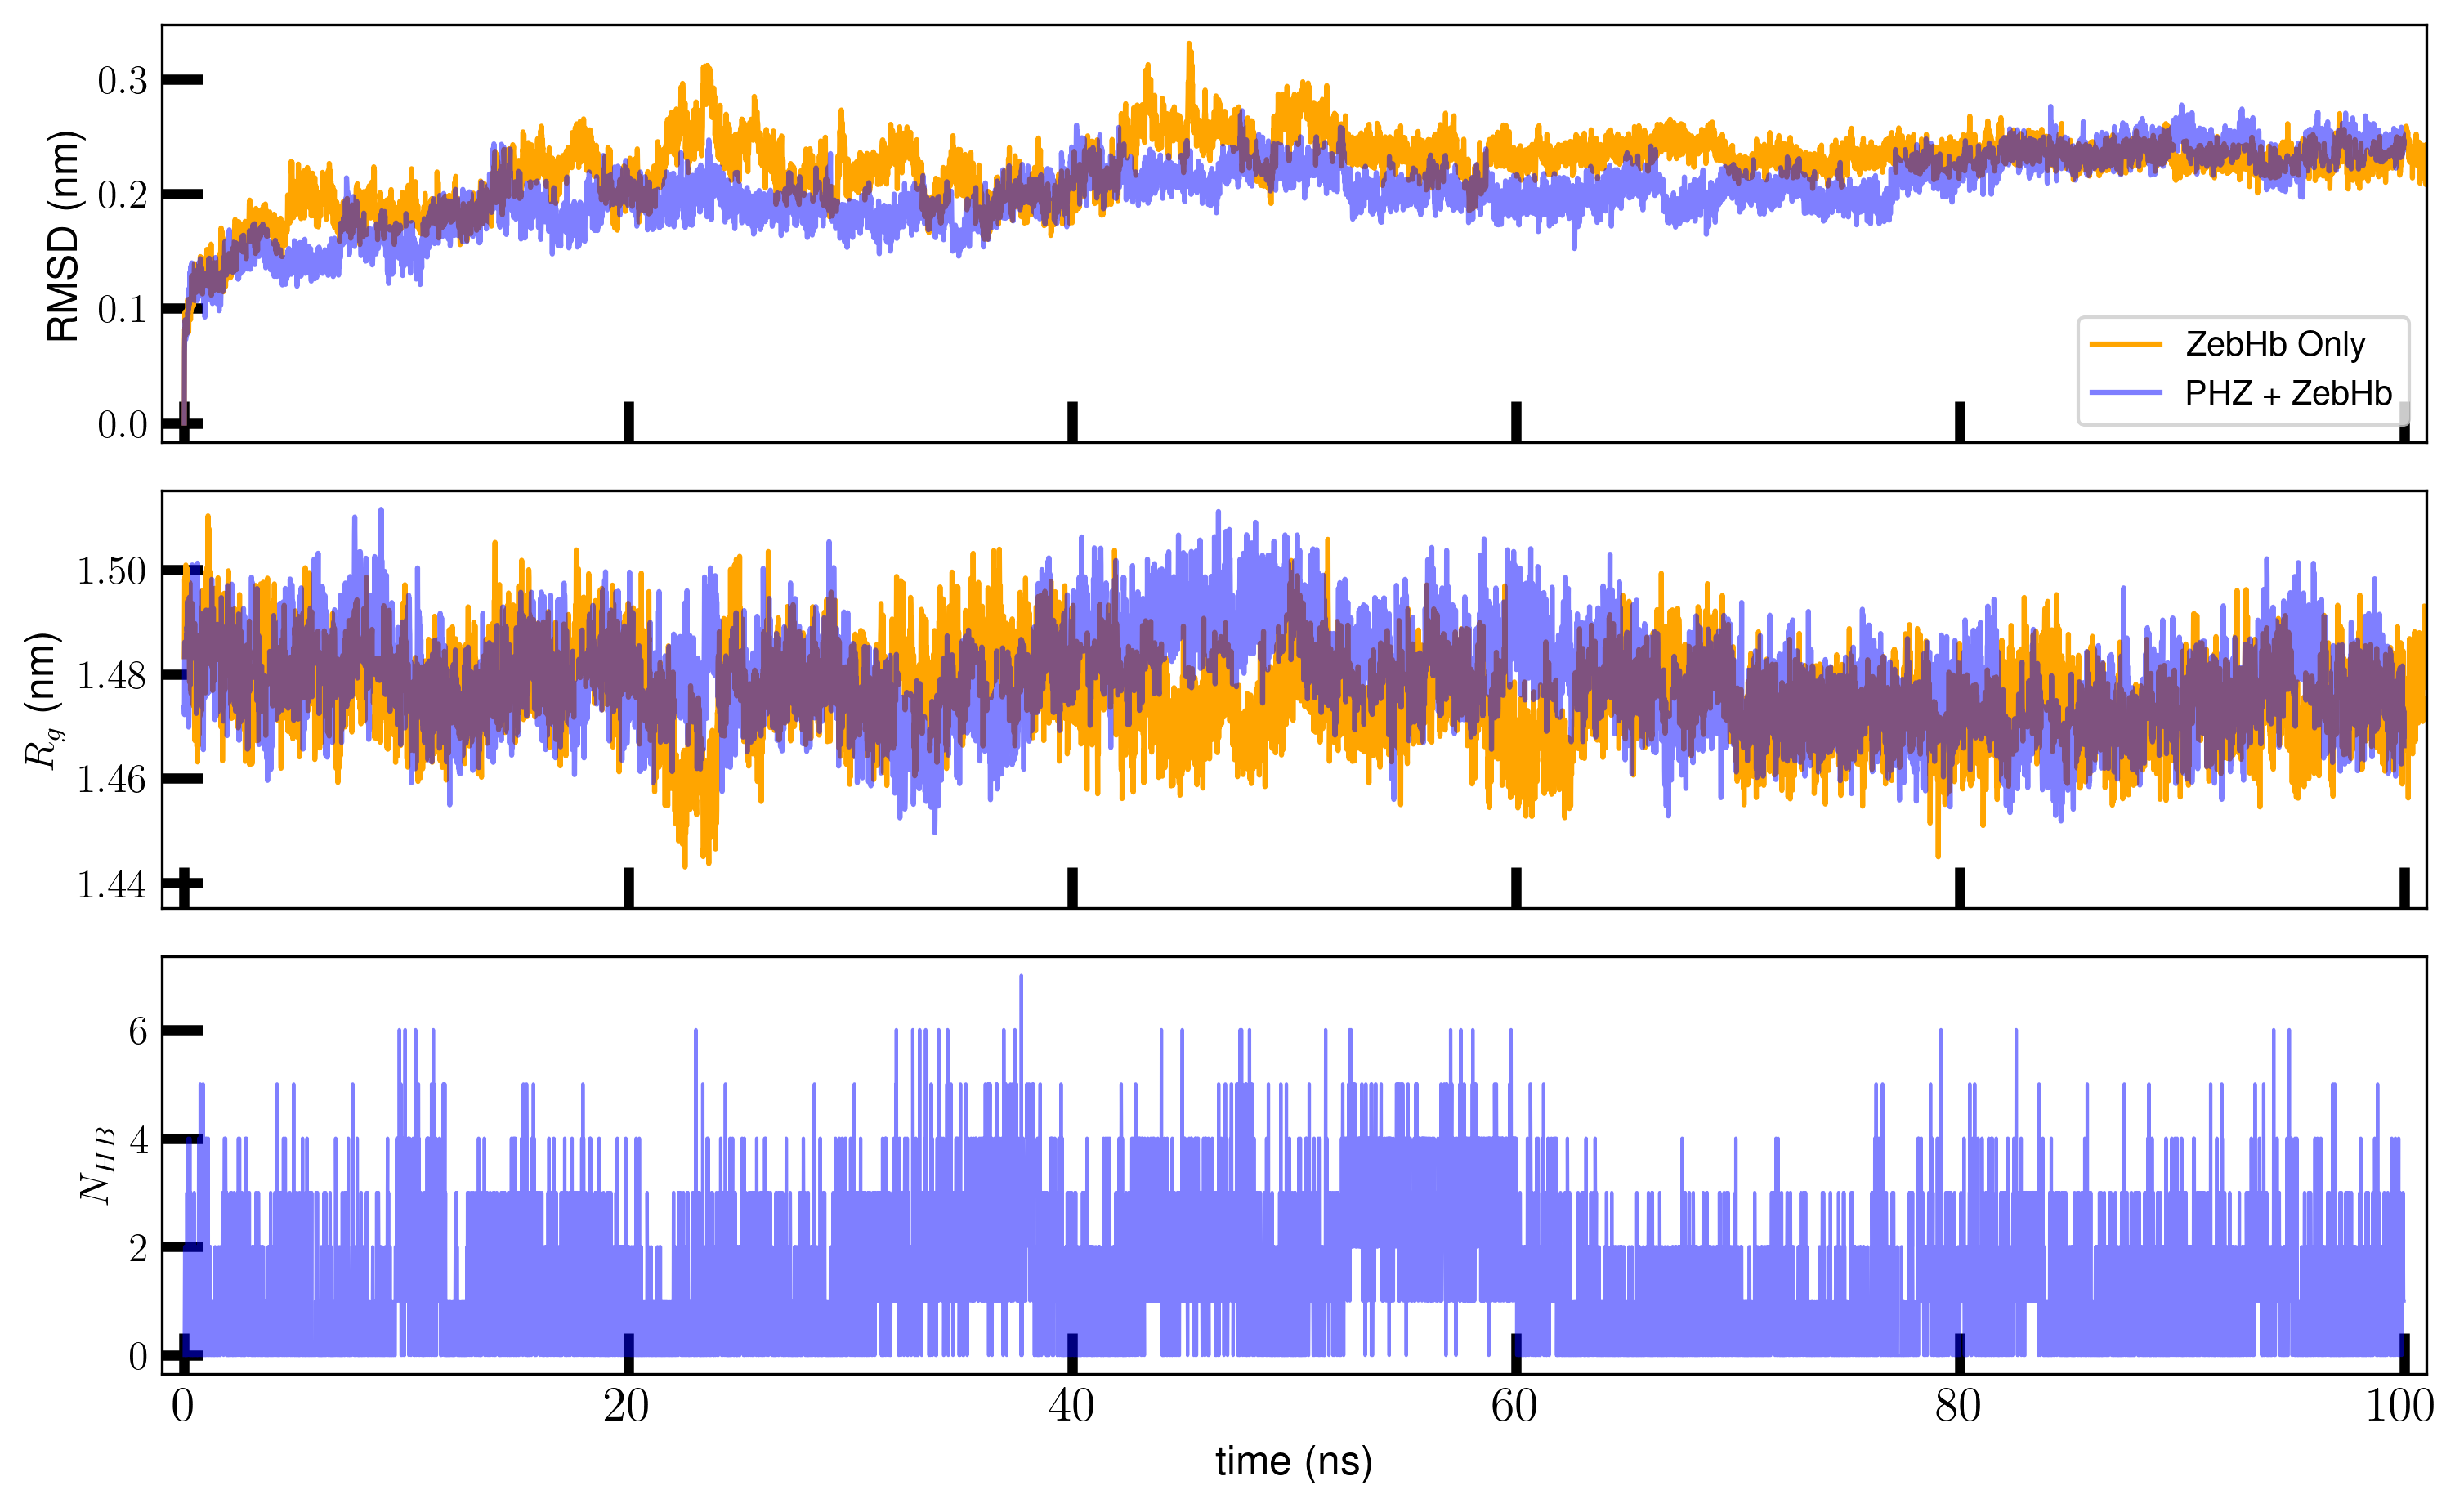

In [88]:
npanels = 3
fig, axs = plt.subplots(npanels,1, sharex=True, tight_layout=True, figsize = (npanels * my_width, npanels*my_width/golden))

ax_rmsd = axs[0]
ax_rmsd.set_ylabel(r'RMSD (nm)');

ax_rmsd.plot(times_p/1000, rmsd_p/10, label="ZebHb Only", 
            color='orange')
ax_rmsd.plot(times_c/1000, rmsd_c/10, label="PHZ + ZebHb", 
            alpha=0.5, color='blue')

ax_rmsd.legend()

ax_rg = axs[1]
ax_rg.plot(Rgyrp_table[:,1]/1000, Rgyrp_table[:,2]/10, 
        label="ZebHb Only", color='orange')
ax_rg.plot(Rgyrc_table[:,1]/1000, Rgyrc_table[:,2]/10, 
        label="PHZ + ZebHb", alpha=0.5,color='blue')
ax_rg.set_ylabel(r'$R_g$ (nm)');

ax_bonds = axs[2]
ax_bonds.set_xlabel(r'time (ns)');
ax_bonds.set_xlim(-1, 101);

ax_bonds.plot(hbonds_phz_prot.times/1000, hbonds_phz_prot.count_by_time(), 
            lw=1, label="PHZ + ZebHb", alpha=0.5,color='blue')

#plt.title("Number of hydrogon bonds over time", weight="bold")
ax_bonds.set_ylabel(r"$N_{HB}$")
plt.savefig("time-series-plots.png", dpi=600)
plt.show()


/tmp/ipykernel_36800/2923783053.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')


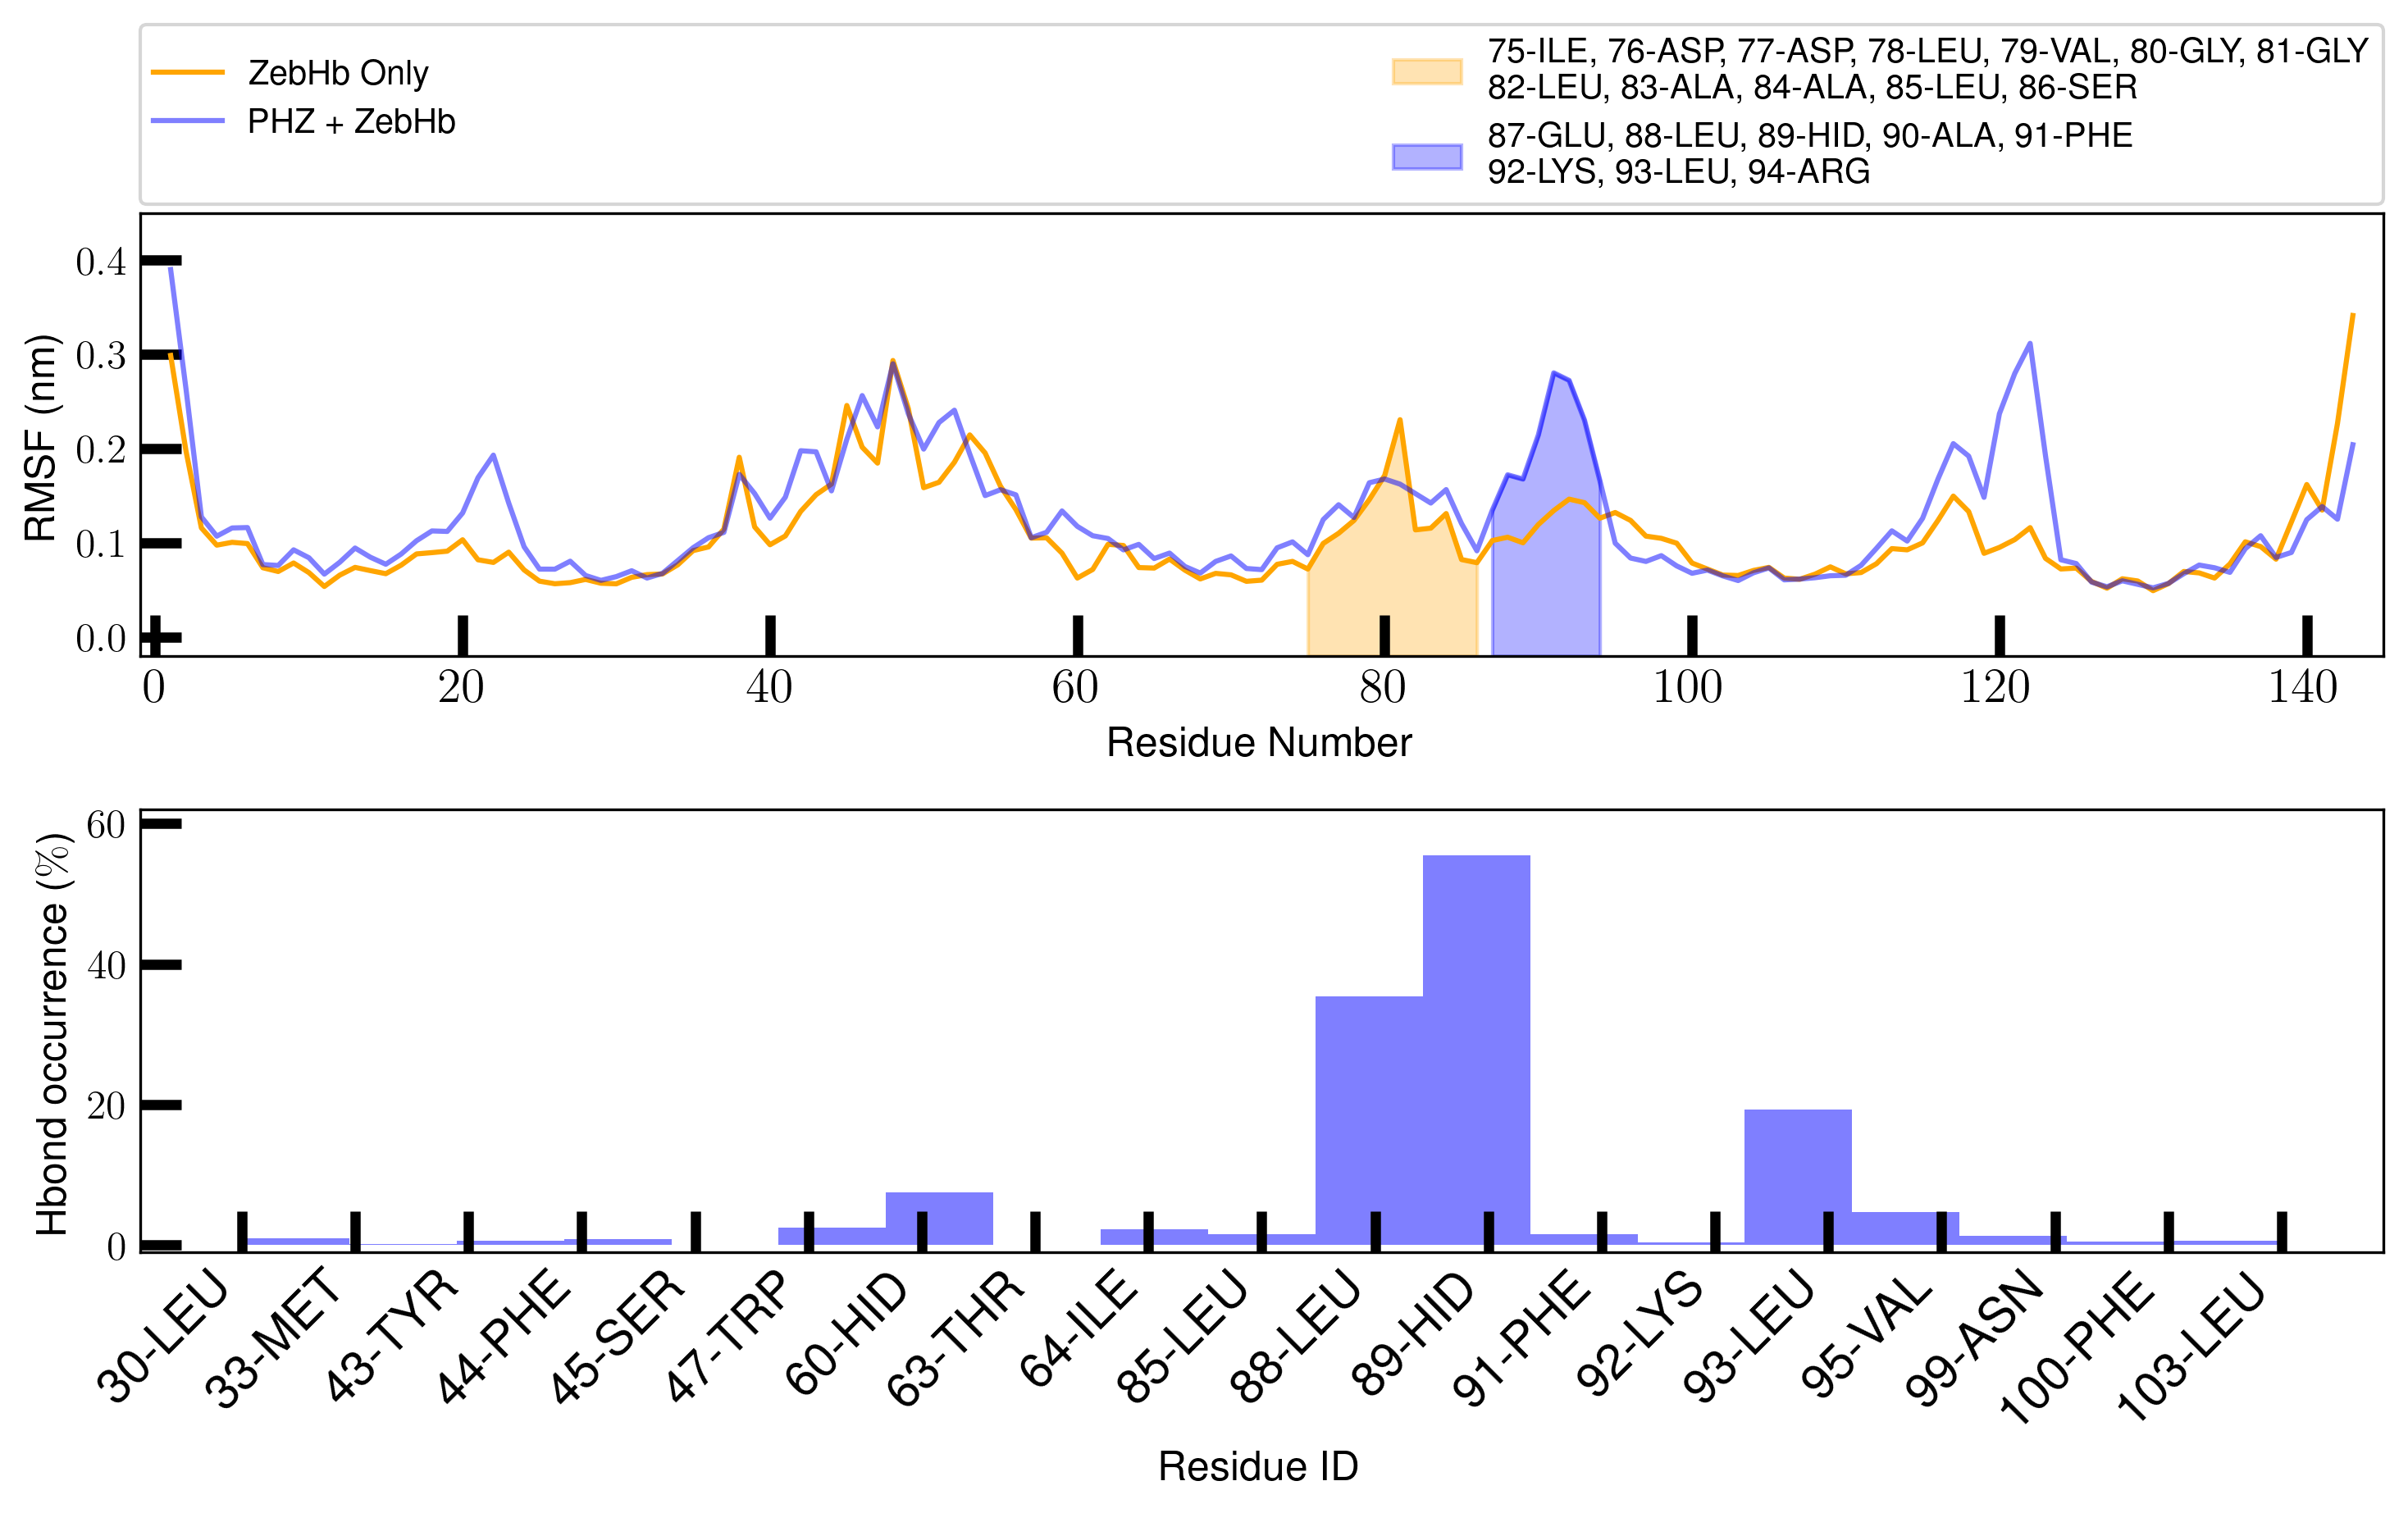

In [90]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (npanels*my_width, npanels*my_width/golden))

line_p, = ax1.plot(c_alphas_p.resids, R_p_half.results.rmsf/10, label="ZebHb Only", 
                color="orange")
line_c, = ax1.plot(c_alphas_c.resids, R_c.results.rmsf/10, label="PHZ + ZebHb", 
                alpha=0.5, color="blue")

def fill_resids(ax, resids, rmsf, label, color):
    resnames = ''
    for idx, resid in enumerate(resids):
        residues = protein_prod.select_atoms(f'resid {resid}')
        resnames += f'{resid}-{residues.resnames[0]}'
        if idx == len(resids)//2:
            resnames += '\n'
        else:
            resnames += ', ' if resid != resids[-1] else '' 
        
    ax.fill_between(resids, -0.02, rmsf[resids-1]/10, alpha=0.3, label=resnames,color=color)

fill_resids(ax1, np.arange(75, 87), R_p_half.results.rmsf, "ZebHb Only",line_p.get_color())
fill_resids(ax1, np.arange(87, 95), R_c.results.rmsf, "PHZ + ZebHb",line_c.get_color())


ax1.set_xlabel('Residue Number')
ax1.set_ylabel('RMSF (nm)')
ax1.set_xlim(-1, 145)
ax1.set_ylim(-0.02, 0.45)
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
            ncols=2, mode="expand", borderaxespad=0.)

sorted_acceptors = sorted(acceptors, key=lambda x: int(x.split('-')[0]))

ax2.hist(sorted_acceptors, bins=len(set(sorted_acceptors)), weights=np.ones(len(sorted_acceptors)) * 100/hbonds_phz_prot.n_frames, color= "blue", alpha=0.5, align='mid')

ax2.set_xlabel('Residue ID')
ax2.set_ylabel("Hbond occurrence " + r"($\%$)")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_ylim(-1, 62)
plt.savefig("rmsf-hbonds.png", dpi=600)
plt.tight_layout()

## TODO

Take the top three residues from the histogram above and rerun hbonds with each uniquely selected, the hbonds donor and acceptor atoms keep changing.